This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:     2531
Number of nonzeros in Lagrangian Hessian.............:      715

Total number of variables............................:      197
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:      701
        inequality constraints with only lower bounds:       53
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      648

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4423454e+01 4.94e+03 3.44e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

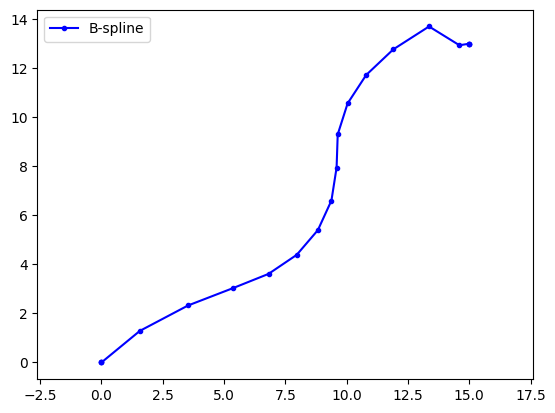

控制点:
 [[2.36937404e-38 6.17313304e-40]
 [1.41189417e-38 3.65575282e-40]
 [3.43340464e-39 1.58881663e-39]
 [1.56738928e+00 1.28870451e+00]
 [3.53342784e+00 2.32524143e+00]
 [5.34843790e+00 3.02580660e+00]
 [6.81329197e+00 3.61201529e+00]
 [7.96305268e+00 4.38901919e+00]
 [8.82685488e+00 5.39821775e+00]
 [9.37931893e+00 6.60427969e+00]
 [9.58986158e+00 7.94736858e+00]
 [9.63569294e+00 9.30014502e+00]
 [1.00389932e+01 1.05640247e+01]
 [1.07953549e+01 1.17228603e+01]
 [1.19023895e+01 1.27689348e+01]
 [1.33600345e+01 1.37022682e+01]
 [1.45984506e+01 1.29368813e+01]
 [1.50000000e+01 1.30000000e+01]
 [1.50000000e+01 1.30000000e+01]
 [1.50000000e+01 1.30000000e+01]]
dt 初猜: 0.4291600302606759


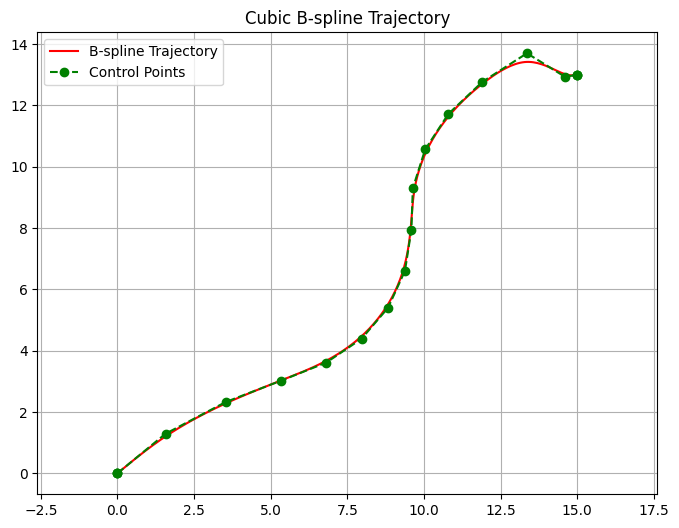

In [20]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from casadi import Opti
import casadi as ca

POINTS = [[0, 0], [1.694694683941254, 0.606638218562969], [2.41161502497284, 2.2577061228646524], [3.6584328542451665, 3.555953133494233], [5.198066437508546, 2.623468050885636], [6.959109611208163, 2.9959287070172405], [7.329028305793068, 4.757507589553189], [9.110921360759477, 5.0121782409099325], [10.17906930889054, 6.460991534921073], [9.828964401880953, 8.226615094485172], [8.411605285941157, 9.336161459655358], [9.78342230289962, 10.800268125979157], [11.44199298470831, 11.499655925018173], [12.820284037993527, 12.657375136413547], [14.598450593061717, 12.936881312439995], [15.0, 13.0]]
obstacles =[[[6.082392200292394, 5.0], [5.765366864730179, 5.765366864730179], 
  [5.0, 6.082392200292394], [4.234633135269821, 5.765366864730179], 
  [3.917607799707606, 5.0], [4.23463313526982, 4.234633135269821], 
  [5.0, 3.917607799707606], [5.765366864730179, 4.23463313526982]], 
 [[3.164784400584788, 5.0], [2.5307337294603593, 6.530733729460359], 
  [1.0000000000000002, 7.164784400584788], [-0.5307337294603591, 6.530733729460359], 
  [-1.164784400584788, 5.0], [-0.5307337294603596, 3.4692662705396407], 
  [0.9999999999999996, 2.835215599415212], [2.5307337294603585, 3.4692662705396407]], 
 [[11.164784400584788, 1.0], [10.530733729460358, 2.5307337294603593], 
  [9.0, 3.164784400584788], [7.469266270539641, 2.5307337294603593], 
  [6.835215599415212, 1.0000000000000002], [7.469266270539641, -0.5307337294603591], 
  [9.0, -1.164784400584788], [10.530733729460358, -0.5307337294603596]], 
 [[13.082392200292395, 8.0], [12.76536686473018, 8.76536686473018], 
  [12.0, 9.082392200292395], [11.23463313526982, 8.76536686473018], 
  [10.917607799707605, 8.0], [11.23463313526982, 7.234633135269821], 
  [12.0, 6.917607799707606], [12.76536686473018, 7.23463313526982]]] 
hd_list = []

def add_linear_separation(opti, Qk, Pj, margin):
    
    Qk = Qk.T
    Pj = Pj.T
    print("Qk shape:", Qk.shape)
    print("Pj shape:", Pj.shape)

    h = opti.variable(2, 1)            
    d = opti.variable()                

    Nq = Qk.shape[1]                    
    Np = Pj.shape[1]                     

    opti.subject_to(h.T @ Qk >= (d + margin) * ca.DM.ones(1, Nq)) 
    opti.subject_to(h.T @ Pj <= (d + margin) * ca.DM.ones(1, Np))


    opti.subject_to(ca.norm_2(h) >= 1e-2)

    opti.set_initial(h, [1.0, 0.0])
    opti.set_initial(d, 0.0)
    return h, d  

def b_spline(path, obstacles):

    X = np.array(path)
    obstacles = [ca.DM(np.array(oct)) for oct in obstacles]

    q0 = np.vstack([
        np.repeat(X[:1], 2, axis=0),   
        X,                            
        np.repeat(X[-1:], 2, axis=0)   
    ])          

    n_rrt = X.shape[0]
    N = n_rrt + 4        

    opti = ca.Opti()

    q = opti.variable(N, 2)
    dt = opti.variable()

    opti.subject_to(dt >= 0.05)
    opti.subject_to(dt <= 0.5)
    
    p0 = ca.DM(X[0]).T              
    pN = ca.DM(X[-1]).T            

    opti.subject_to(q[0:3, :] == ca.repmat(p0, 3, 1)) 
    opti.subject_to(q[-3:, :] == ca.repmat(pN, 3, 1))  


    m = (1/6) * ca.DM([1, 4, 1, 0])            
    b = ca.DM([-1, 3, -3, 1])                    

    fit_cost, jerk_cost = 0, 0

        

    for k in range(3, N-4):                      
        Qk = ca.vcat([
            q[k-3, :],
            q[k-2, :],
            q[k-1, :],
            q[k  , :]
        ])                         

        if k >= 4:
            vk = (q[k, :] - q[k-1, :]) / dt
            opti.subject_to(ca.sumsqr(vk) <= 10**2)
    
        if k >= 5:
            ak = (q[k, :] - 2*q[k-1, :] + q[k-2, :]) / dt**2
            opti.subject_to(ca.sumsqr(ak) <= 2**2)

        for Pj in obstacles:          
            h, d = add_linear_separation(opti, Qk, Pj, margin=0.1)
            hd_list.append((h, d, Qk, Pj))


        pk = m.T @ Qk 
        ref = ca.DM(X[k-3]).T           
        fit_cost  += ca.sumsqr(pk - ref)       
        jerk_cost += ca.sumsqr(b.T @ Qk) 
        
    total_time = (N-3)*dt
    opti.minimize(fit_cost + 0.3*jerk_cost + total_time)
    opti.set_initial(q, q0)
    opti.set_initial(dt, 0.2)
    opti.solver('ipopt')
    sol = opti.solve()

    q_star = np.array(sol.value(q))

    return q_star, sol.value(dt)

q_star, dt0 = b_spline(POINTS,obstacles)

plt.plot(q_star[:, 0], q_star[:, 1], 'b.-', label='B-spline')
plt.axis('equal')
plt.legend()
plt.show()
print("控制点:\n", q_star)
print("dt 初猜:", dt0)


def eval_bspline(q, t):
    """
    用 B 样条控制点 q (N×2) 计算参数 t ∈ [3, N-1] 时的曲线位置 (1×2)
    """
    k = int(np.floor(t))       # 当前段索引
    u = t - k                  # 局部参数 ∈ [0, 1]

    Qk = q[k-3:k+1, :]         # 取4个控制点，shape: (4×2)

    # Cubic B-spline 系数矩阵 M（固定）
    M = (1/6) * np.array([
        [1,  4,  1,  0],
        [-3, 0,  3,  0],
        [3, -6,  3,  0],
        [-1, 3, -3,  1]
    ])                         # shape: (4×4)

    U = np.array([1, u, u**2, u**3])    # 1×4
    return U @ M @ Qk                   # 1×2

# ✅ 曲线采样函数（整条曲线）
def generate_bspline_path(q, num_points=300):
    t_vals = np.linspace(3, len(q)-1, num_points)  # 参数 t ∈ [3, N-1]
    return np.array([eval_bspline(q, t) for t in t_vals])

# ✅ 生成曲线
curve = generate_bspline_path(q_star)

# ✅ 可视化
plt.figure(figsize=(8,6))
plt.plot(curve[:,0], curve[:,1], 'r-', label='B-spline Trajectory')
plt.plot(q_star[:,0], q_star[:,1], 'go--', label='Control Points')
plt.title("Cubic B-spline Trajectory")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

violated = 0

for i, (h, d, Qk, Pj) in enumerate(hd_list):
    h_val = np.array(opti.value(h)).reshape(2,)
    d_val = float(opti.value(d))
    
    Qk_pts = np.array(Qk)
    Pj_pts = np.array(Pj)

    Qk_proj = h_val.T @ Qk_pts
    Pj_proj = h_val.T @ Pj_pts

    q_min = np.min(Qk_proj)
    p_max = np.max(Pj_proj)

    margin = 0.1

    if q_min < d_val + margin or p_max > d_val - margin:
        print(f"❌ 分离失败 at pair {i}: q_min={q_min:.3f}, p_max={p_max:.3f}, d={d_val:.3f}")
        violated += 1

print(f"⚠️ 有 {violated} 个障碍分离约束未被满足")
